In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import transforms
import matplotlib.patches as patches

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm


import cv2
import os
from imageio import imread
from glob import glob
import json

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score

import time
from torchvision.ops import nms

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 

In [ ]:
#Function to extract frames
def extractFrames(pathIn, pathOut):
   #directory path, where my video images will be stored
   os.mkdir(pathOut)
   #Capture video from video file
   cap = cv2.VideoCapture(pathIn)
#Counter Variable
   count = 0
   while (cap.isOpened()):
     # Capture frame-by-frame
     ret, frame = cap.read()
     if ret == True:
       # save frame as JPEG file
       cv2.imwrite(os.path.join(pathOut, "frame{:d}.jpg".format(count)), frame)
       count += 1
     else:
       break
    # When everything done, release the capture
   cap.release()
   cv2.destroyAllWindows()

In [ ]:
extractFrames('/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/Bridge.mp4',
              '/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/Bridge__')

In [ ]:
extractFrames('/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/Street.mp4',
              '/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/Street__')

In [ ]:
from PIL import Image
import glob

In [ ]:
Bridge_frames = []
for filename in glob.glob('/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/Bridge___/*.jpg'):  ## using glob to pull all the image files in the bridge directory
    im=cv2.imread(filename)                                                                                
    Bridge_frames.append(im)

In [ ]:
Street_frames = []
for filename in glob.glob('/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/Street___/*.jpg'):
    im=cv2.imread(filename)
    Street_frames.append(im)

In [ ]:
from google.colab.patches import cv2_imshow


In [ ]:
Bridge_pred= []
for filename in glob.glob('/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/pred_bridge/*.png'):  ## using glob to pull all the image files in the bridge directory
    im=cv2.imread(filename)                                                                                
    Bridge_pred.append(im)

In [ ]:
Street_pred = []
for filename in glob.glob('/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/pred_Street/*.png'):  ## using glob to pull all the image files in the bridge directory
    im=cv2.imread(filename)                                                                                
    Street_pred.append(im)

In [ ]:
len(Bridge_pred)

480

In [ ]:
def order_points(pts):
	
	rect = np.zeros((4, 2), dtype = "float32")
	
	s = np.sum(pts,axis = 1)
	rect[0] = pts[0]
	rect[2] = pts[2]
	
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[1]
	rect[3] =pts[3] 
	# return the ordered coordinates
	return rect

In [ ]:
def four_point_transform(image, pts):
	
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped

In [ ]:
pts = [(600,0),(1280,0),(1100,720),(0,300)]

In [ ]:
order_points(pts)

array([[ 600.,    0.],
       [1280.,    0.],
       [1100.,  720.],
       [   0.,  300.]], dtype=float32)

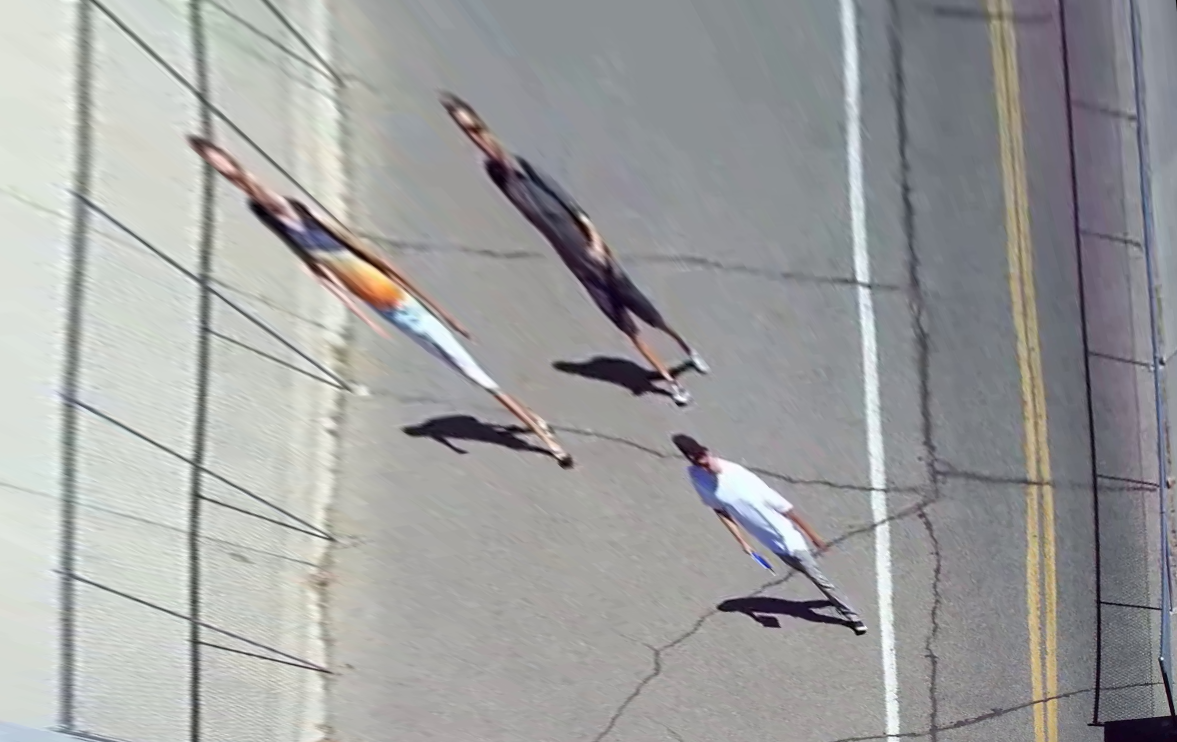

In [ ]:
cv2_imshow(four_point_transform(Bridge_frames[0],pts))

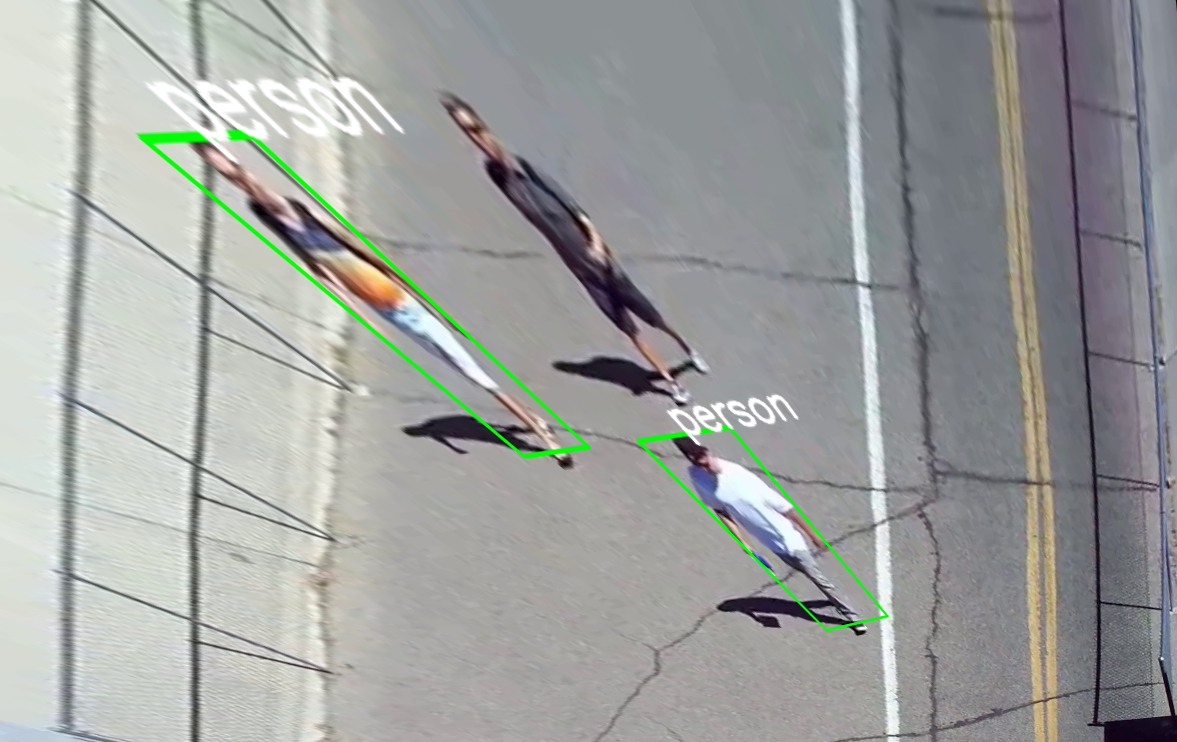

In [ ]:
cv2_imshow(four_point_transform(Bridge_pred[0],pts))

In [ ]:
os.mkdir('/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/bird_pred')

In [ ]:
for i in range(0,len(Bridge_pred)):
  warped = four_point_transform(Bridge_pred[i],pts)
  cv2.imwrite(f'/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/bird_pred/bird{i}.png',warped)


In [ ]:
import cv2
import re
import numpy as np
import os
from os.path import isfile, join
pathIn= '/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/bird_pred/'
pathOut = '/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/bird_bridge.avi'
array_frames = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly
files.sort(key = lambda x: int(re.sub('\D', '', x)))

for i in range(len(files)):
    filename=pathIn + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    array_frames.append(img)
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), 24, size)
for i in range(len(array_frames)):
    # writing to a image array
    out.write(array_frames[i])
out.release()

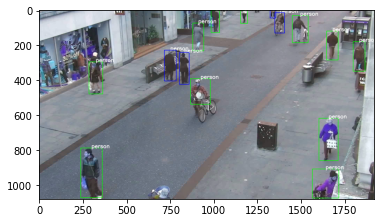

In [ ]:
plt.imshow(Street_pred[0])

In [ ]:
Street_pred[0].shape

(1080, 1920, 3)

In [ ]:
street_pts = [(1000,0),(1900,0),(1750,1080),(0,500)]

In [ ]:
pts = street_pts

In [ ]:
os.mkdir('/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/bird_strt')

In [ ]:
for i in range(0,len(Street_pred)):
  warped = four_point_transform(Street_pred[i],pts)
  cv2.imwrite(f'/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/bird_strt/bird{i}.png',warped)

In [ ]:
import cv2
import re
import numpy as np
import os
from os.path import isfile, join
pathIn= '/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/bird_strt/'
pathOut = '/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/bird_street.avi'
array_frames = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly
files.sort(key = lambda x: int(re.sub('\D', '', x)))

for i in range(len(files)):
    filename=pathIn + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    array_frames.append(img)
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), 24, size)
for i in range(len(array_frames)):
    # writing to a image array
    out.write(array_frames[i])
out.release()